### Multi-Objective Problems using NSGA-II

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

In [2]:
# Problem definition, both objectives must be minimizing

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_ieq_constr=2, # Only inequalities (<=) can be processed
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9)
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) # flipped inequality

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


problem = MyProblem()

In [3]:
# Algorithm definition
algorithm = NSGA2(
    pop_size=400,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Termination criterion
termination = get_termination("n_gen", 40)


# Optimize
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

F1 = res.F[:, 0]
F2 = -res.F[:, 1]

print("--"*50)

# Utopy point
min1 = min(F1)
max2 = max(F2)
print("Utopy point: ", min1, max2)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      400 |      5 |  0.000000E+00 |  2.8928985195 |             - |             -
     2 |      500 |      6 |  0.000000E+00 |  1.1855026294 |  0.0849683793 |         ideal
     3 |      600 |      9 |  0.000000E+00 |  0.5290150564 |  0.0335563199 |         ideal
     4 |      700 |     12 |  0.000000E+00 |  0.2339971000 |  0.0205657672 |         ideal
     5 |      800 |     16 |  0.000000E+00 |  0.0899740174 |  0.0061225117 |         nadir
     6 |      900 |     19 |  0.000000E+00 |  0.0318570964 |  0.0055150619 |             f
     7 |     1000 |     25 |  0.000000E+00 |  0.0040394121 |  0.0064600989 |             f
     8 |     1100 |     32 |  0.000000E+00 |  0.000000E+00 |  0.0096677079 |             f
     9 |     1200 |     36 |  0.000000E+00 |  0.000000E+00 |  0.0029156419 |             f
    10 |     1300 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0023873101 |             f

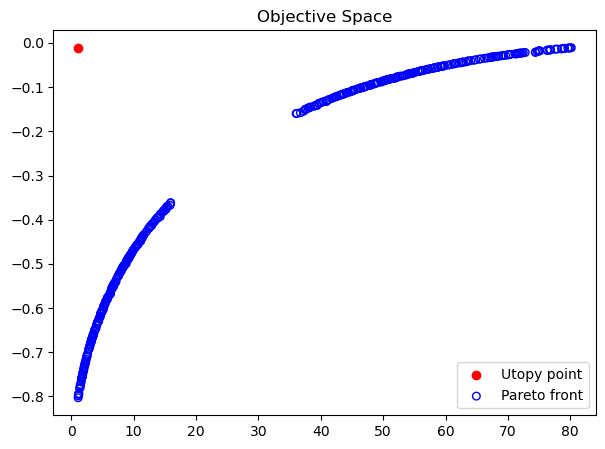

In [4]:
plt.figure(figsize=(7, 5))
plt.scatter(min1, max2, color="red", label="Utopy point")
plt.scatter(res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue', label="Pareto front")
plt.title("Objective Space")
plt.legend(loc="best")
plt.show()

In [5]:
# Normalization
scaler1 = preprocessing.MinMaxScaler()
scaler2 = preprocessing.MinMaxScaler()
F1_scaled = scaler1.fit_transform(F1.reshape(-1, 1))
F2_scaled = scaler2.fit_transform(F2.reshape(-1, 1))


# Best point
dis = lambda x,y: np.sqrt((x-min(F1_scaled))**2 + (y-max(F2_scaled))**2).item()
dis_vec = []

for x, y in zip(F1, F2):
    dis_vec.append(dis(x, y))

dis_vec = np.array(dis_vec)
ind = np.argmin(dis_vec)

real1 = scaler1.inverse_transform(F1_scaled[ind].reshape(-1, 1))[0][0]
real2 = scaler2.inverse_transform(F2_scaled[ind].reshape(-1, 1))[0][0]
print("Best Pareto point: ", real1, real2)

Best Pareto point:  1.0961715121519218 -0.8029570784865286


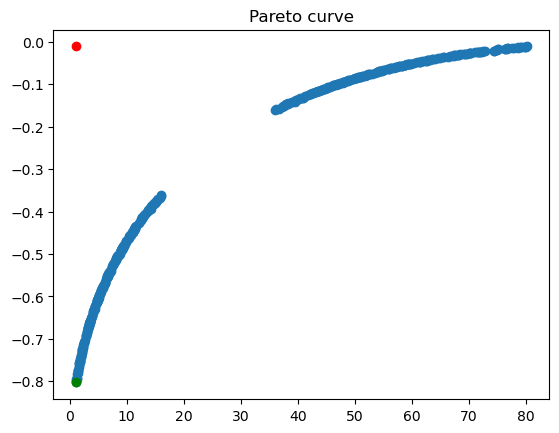

In [6]:
plt.title("Pareto curve")
plt.scatter(F1, F2)
plt.scatter(min1, max2, color="red")
plt.scatter(real1, real2, color="green")
plt.show()